## Modeling

In [51]:
import numpy as np
import pandas as pd
import env
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#Acquire the data
zillow = wrangle.wrangle_zillow()

In [3]:
#Split the data into train, validate, and test
train, validate, test = wrangle.train_validate_test_split(zillow)

In [4]:
#Split into X and y groups
X_train, y_train = train.drop('tax_value', axis = 1), train.tax_value
X_validate, y_validate = validate.drop('tax_value', axis = 1), validate.tax_value
X_test, y_test = test.drop('tax_value', axis = 1), test.tax_value

In [6]:
#Now scale the X groups using the Robust Scaler
#Create the scaler
scaler = RobustScaler()

#Fit the scaler on X_train
scaler.fit(X_train)

#Transform the data
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

#Assign the scaled columns as new columns in each set
cols_scaled = ['bedroom_count_scaled', 'bathroom_count_scaled', 'home_area_scaled']
train[cols_scaled] = X_train_scaled
validate[cols_scaled] = X_validate_scaled
test[cols_scaled] = X_test_scaled

/Users/johnathonsmith/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [7]:
#Compare the new and original distributions just to be sure everything is okay
def compare_dists(cols_to_scale, cols_scaled):
    plt.figure(figsize=(13,6))

    for i, col in enumerate(cols_to_scale):
        i += 1
        plt.subplot(2,4,i)
        train[col].plot.hist()
        plt.title(col)

    for i, col in enumerate(cols_scaled):
        i += 5
        plt.subplot(2,4,i)
        train[col].plot.hist()
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [9]:
X_train.head()

,bedroom_count,bathroom_count,home_area
23141,4,3.0,3044
2687,4,3.0,2398
27752,3,2.0,1088
6339,3,2.0,1598
4036,3,3.0,2472


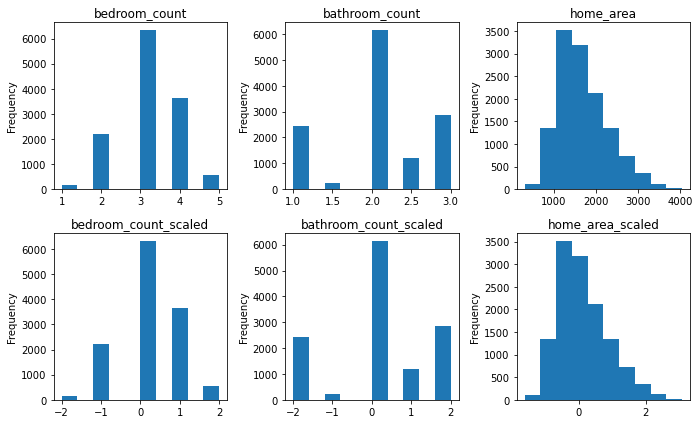

In [12]:
cols_to_scale = ['bedroom_count', 'bathroom_count', 'home_area']
compare_dists(train[cols_to_scale], train[cols_scaled])

In [18]:
#Distributions appear to be the same, so its okay to move forward.
#Now create a baseline to compare our future model to.
#Change y_train and y_validate to be data frames so we can store the baseline values in them
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Calculate baseline based on mean
baseline_mean_pred = y_train.tax_value.mean()
y_train['baseline_mean_pred'] = baseline_mean_pred
y_validate['baseline_mean_pred'] = baseline_mean_pred

#Calculate baseline based on median
baseline_median_pred = y_train.tax_value.median()
y_train['baseline_median_pred'] = baseline_median_pred
y_validate['baseline_median_pred'] = baseline_median_pred

#Calculate RMSE based on mean
train_RMSE = mean_squared_error(y_train.tax_value, y_train['baseline_mean_pred']) ** .5
validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate['baseline_mean_pred']) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2),
     "\n")

#Calculate RMSE based on median
train_RMSE = mean_squared_error(y_train.tax_value, y_train['baseline_median_pred']) ** .5
validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate['baseline_median_pred']) ** .5

print("RMSE using Median\nTrain/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2))

RMSE using Mean
Train/In-Sample:  262170.33 
Validate/Out-of-Sample:  258013.69 

RMSE using Median
Train/In-Sample:  265401.28 
Validate/Out-of-Sample:  261213.09


Since the mean baseline prediction has a smaller RMSE than the median baseline prediction, I will use that one for the final report.

In [20]:
#Now set up the linear regression model
#Create the model
lm = LinearRegression(normalize = True)

#Fit the model on scaled data
lm.fit(X_train_scaled, y_train.tax_value)

#Make predictions
y_train['lm_preds'] = lm.predict(X_train_scaled)
y_validate['lm_preds'] = lm.predict(X_validate_scaled)

#Calculate the RMSE
train_RMSE = mean_squared_error(y_train.tax_value, y_train['lm_preds']) ** .5
validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate['lm_preds']) ** .5

print("RMSE using OLS\nTrain/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2))

RMSE using OLS
Train/In-Sample:  236525.67 
Validate/Out-of-Sample:  233033.15


In [24]:
#Now set up the LassoLars, start with an alpha of 1.
#After MVP, set up a loop to try more values of alpha

for i in range(1, 101, 10):
    #Create the model
    lars = LassoLars(alpha = i)
    
    #Fit the model
    lars.fit(X_train_scaled, y_train.tax_value)
    
    #Make predictions
    y_train[f'lars_alpha_{i}'] = lars.predict(X_train_scaled)
    y_validate[f'lars_alpha_{i}'] = lars.predict(X_validate_scaled)
    
    #Calculate RMSE
    train_RMSE = mean_squared_error(y_train.tax_value, y_train[f'lars_alpha_{i}']) ** .5
    validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate[f'lars_alpha_{i}']) ** .5
    
    print(f'\nRMSE using LassoLars, alpha = {i}')
    print("Train/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2))


RMSE using LassoLars, alpha = 1
Train/In-Sample:  236525.82 
Validate/Out-of-Sample:  233023.21

RMSE using LassoLars, alpha = 11
Train/In-Sample:  236544.58 
Validate/Out-of-Sample:  232941.27

RMSE using LassoLars, alpha = 21
Train/In-Sample:  236594.6 
Validate/Out-of-Sample:  232891.13

RMSE using LassoLars, alpha = 31
Train/In-Sample:  236675.86 
Validate/Out-of-Sample:  232872.79

RMSE using LassoLars, alpha = 41
Train/In-Sample:  236788.33 
Validate/Out-of-Sample:  232886.27

RMSE using LassoLars, alpha = 51
Train/In-Sample:  236931.96 
Validate/Out-of-Sample:  232931.57

RMSE using LassoLars, alpha = 61
Train/In-Sample:  237106.69 
Validate/Out-of-Sample:  233008.66

RMSE using LassoLars, alpha = 71
Train/In-Sample:  237312.47 
Validate/Out-of-Sample:  233117.51

RMSE using LassoLars, alpha = 81
Train/In-Sample:  237549.2 
Validate/Out-of-Sample:  233258.08

RMSE using LassoLars, alpha = 91
Train/In-Sample:  237816.79 
Validate/Out-of-Sample:  233430.31


Quick Note:

* The lassolars models performed best with alpha between 21 and 41 and beat both the baseline and the OLS model.
* After MVP go back and continue to experiment with alpha.

In [23]:
#Now set up GLM, tweedieRegressor
#Create the model
glm = TweedieRegressor(power = 0, alpha = 1)

#Fit the model
glm.fit(X_train_scaled, y_train.tax_value)

#Make predictions
y_train['glm_preds'] = glm.predict(X_train_scaled)
y_validate['glm_preds'] = glm.predict(X_validate_scaled)

#Calculate RMSE
train_RMSE = mean_squared_error(y_train.tax_value, y_train['glm_preds']) ** .5
validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate['glm_preds']) ** .5

print("RMSE using TweedieRegressor\nTrain/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2))

RMSE using TweedieRegressor
Train/In-Sample:  245043.69 
Validate/Out-of-Sample:  240444.68


In [52]:
#Now set up a polynomial model
#Create new features
pf = PolynomialFeatures(degree = 2)

#Fit to scaled data
X_train_degree2 = pf.fit_transform(X_train_scaled)

#Transform for validate and test as well
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

#Now use linear regression with new features
lm2 = LinearRegression(normalize = True)

#Fit the model
lm2.fit(X_train_degree2, y_train.tax_value)

#Make predicitons
y_train['poly_preds'] = lm2.predict(X_train_degree2)
y_validate['poly_preds'] = lm2.predict(X_validate_degree2)

#Calculate RMSE
train_RMSE = mean_squared_error(y_train.tax_value, y_train['poly_preds']) ** .5
validate_RMSE = mean_squared_error(y_validate.tax_value, y_validate['poly_preds']) ** .5

print("RMSE using Polynomial Features\nTrain/In-Sample: ", round(train_RMSE, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_RMSE, 2))

RMSE using Polynomial Features
Train/In-Sample:  236336.67 
Validate/Out-of-Sample:  232927.54


## Choose Best Model (for MVP)

After test several models, I will choose the LassoLars model with an alpha = 31, since it performed the best so far.

I will wait to evaluate any model on the test set, until I am happy with my chosen model. As of now, I plan to go back and do some feature engineering and play around with the models a bit more.

I will go ahead and graph the residuals for my MVP chosen model.

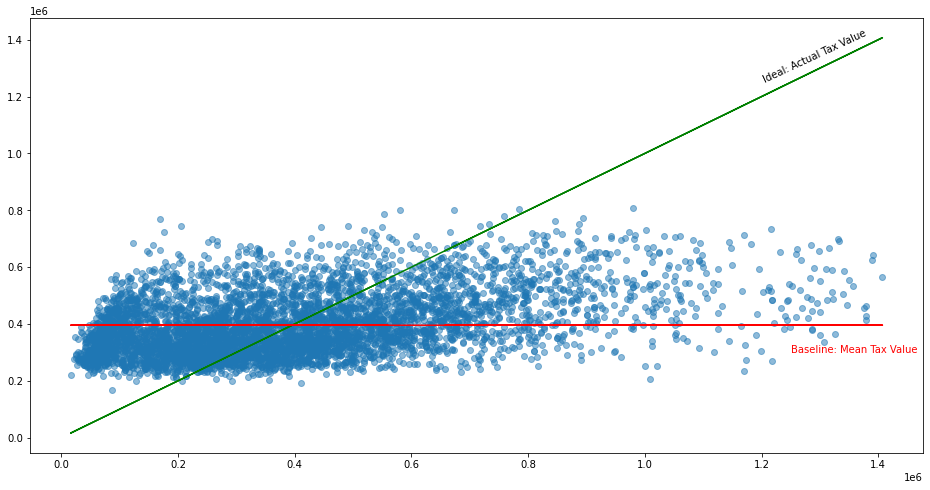

In [49]:
plt.figure(figsize = (16, 8))
plt.plot(y_validate.tax_value, y_validate.tax_value, color = 'green')
plt.plot(y_validate.tax_value, y_validate['baseline_mean_pred'], color = 'red')
plt.scatter(y_validate.tax_value, y_validate['lars_alpha_31'], alpha = 0.5)
plt.annotate('Ideal: Actual Tax Value', (1.2*10**6, 1.25*10**6), rotation = 25)
plt.annotate('Baseline: Mean Tax Value', (1.25*10**6, .3*10**6), color = 'red')
plt.show()

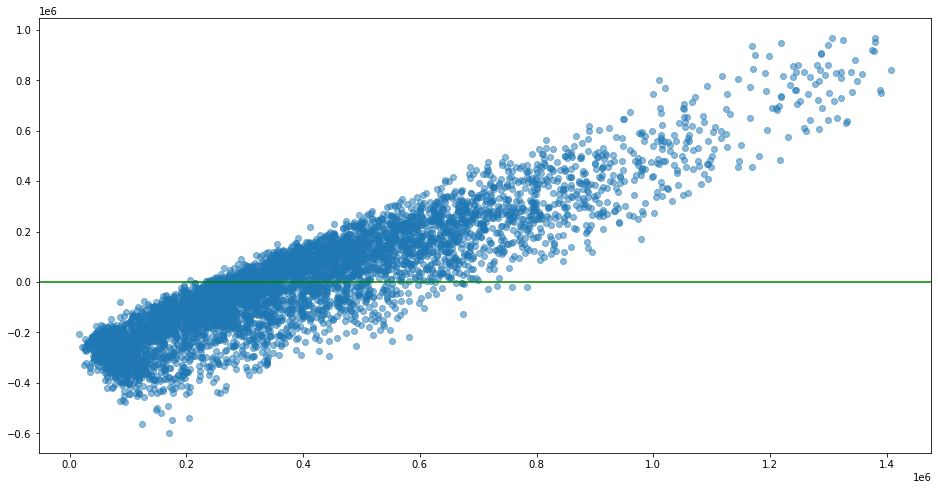

In [47]:
plt.figure(figsize=(16,8))
plt.scatter( y_validate.tax_value, y_validate.tax_value - y_validate['lars_alpha_31'], alpha = .5)
plt.axhline(label="No Error", color = 'green')
plt.show()

There is a strong linear relationship above, and that tells me there is still work to do.